## Introduction ##

Climate change is a prevailing problem for Earth's ecosystem. This project serves to highlight the issues of climate change by understanding historical changes in surface temperatures around the world, and accurately predicting future global temperatures.

The source dataset contains surface temperature records from the 1900 to 2010 for multiple cities and countries around the world. Most of the methods currently in place in the realm of climate change to predict future surface temperatures use classical models for time series forecasting. However, more recent deep learning models such as RNNs and LSTMSs present novel approaches for this. Here, both classical and novel deep learning models are evaluated to determine the most suitable for this. The models considered in this work as the following:

- Long Short Term Memory (LSTM)
- S-ARIMA
- Random Forest
- Decision Trees
- XGBoost
 
The models are trained on 80% of the dataset (1900-1988) and evaluated by using their predictions on the remaining 20% (1989-2010) of the data. It is ensured that the training and validation sets are out of time, i.e. There are no date overlaps between the two ensuring no data leakage. The perfomance of each of the models is evaluated using their mean squared error. Once the most suitable model is found, it is used to predict future surface temperatures. These predictions will be visualized in the associated web interface.

## Import Packages ##

In [1]:
# Import required packages
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import mean_squared_error

## Surface Temperature Prediction Modeling ##

In [2]:
# Set dictionary to store MSE value for each evaluated model
modelMSE = {}

### Model 1: Long Short Term Memory (LSTM) ###

In [3]:
# Import required packages
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None

In [4]:
# Load the cleaned dataset
global_temps = pd.read_csv("./data/global_temps_cleaned.csv")

# Construct the training set
training_set = global_temps[["dt", "LandAverageTemperature"]]
training_set["dt"] = pd.to_datetime(training_set["dt"], format="%Y-%m-%d")
training_set.set_index("dt", inplace=True)
training_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3192 entries, 1750-01-01 to 2015-12-01
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LandAverageTemperature  3192 non-null   float64
dtypes: float64(1)
memory usage: 49.9 KB


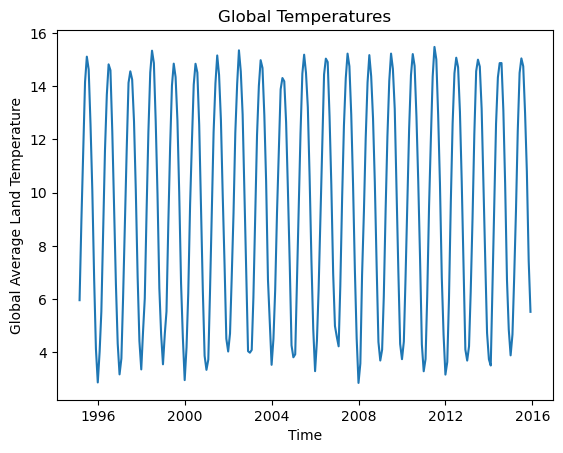

In [5]:
# View data by plotting global surface temperatures
plt.xlabel("Time")
plt.ylabel("Global Average Land Temperature")
plt.title("Global Temperatures")
plt.plot(training_set.tail(250))

In [6]:
# Construct the model
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [7]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

Epoch: 0, loss: 0.40383
Epoch: 100, loss: 0.03055
Epoch: 200, loss: 0.00294
Epoch: 300, loss: 0.00270
Epoch: 400, loss: 0.00262
Epoch: 500, loss: 0.00257
Epoch: 600, loss: 0.00253
Epoch: 700, loss: 0.00251
Epoch: 800, loss: 0.00249
Epoch: 900, loss: 0.00247
Epoch: 1000, loss: 0.00244
Epoch: 1100, loss: 0.00242
Epoch: 1200, loss: 0.00240
Epoch: 1300, loss: 0.00238
Epoch: 1400, loss: 0.00237
Epoch: 1500, loss: 0.00235
Epoch: 1600, loss: 0.00234
Epoch: 1700, loss: 0.00233
Epoch: 1800, loss: 0.00232
Epoch: 1900, loss: 0.00231


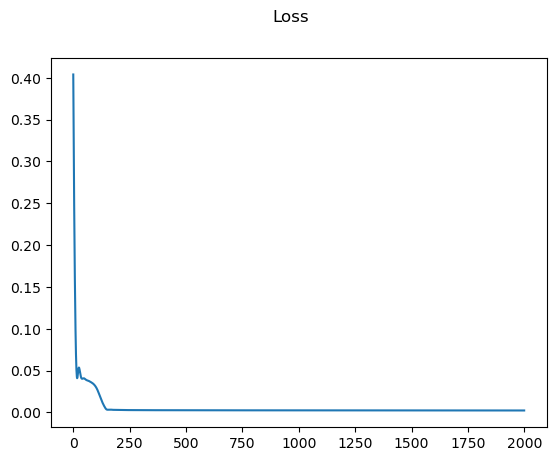

In [8]:
# Set parameters
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 5
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the LSTM model
epoch_number = []
loss_values = []
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    
    epoch_number.append(epoch)
    loss_values.append(loss.item())
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

# Plot the loss function
plt.plot(epoch_number, loss_values)
plt.suptitle('Loss')
plt.show()

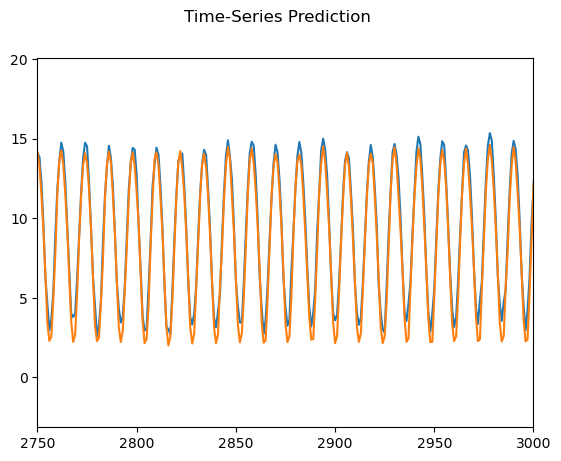

In [9]:
# Evaluate the model
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.xlim(2750,3000)
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [10]:
# Evaluate the performance of the model using MSE
mseLSTM = mean_squared_error(dataY_plot, data_predict)
modelMSE["LSTM"] = mseLSTM

### Model 2: SARIMA ###

In [11]:
# Import required packages
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm

pd.options.mode.chained_assignment = None

In [12]:
# Load the cleaned dataset
city_temps_sarima = pd.read_csv("./data/city_temps_cleaned.csv")
arhus = city_temps_sarima[city_temps_sarima.City == "Århus"]
dates = arhus[["dt", "AverageTemperature"]]
dates["dt"] = pd.to_datetime(dates["dt"], format="%Y-%m-%d")
dates.set_index("dt", inplace=True)
dates.index = pd.DatetimeIndex(dates.index.values, freq=dates.index.inferred_freq)

In [13]:
# Train the SARIMA model
sarima_model = sm.tsa.statespace.SARIMAX(dates, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
result = sarima_model.fit()

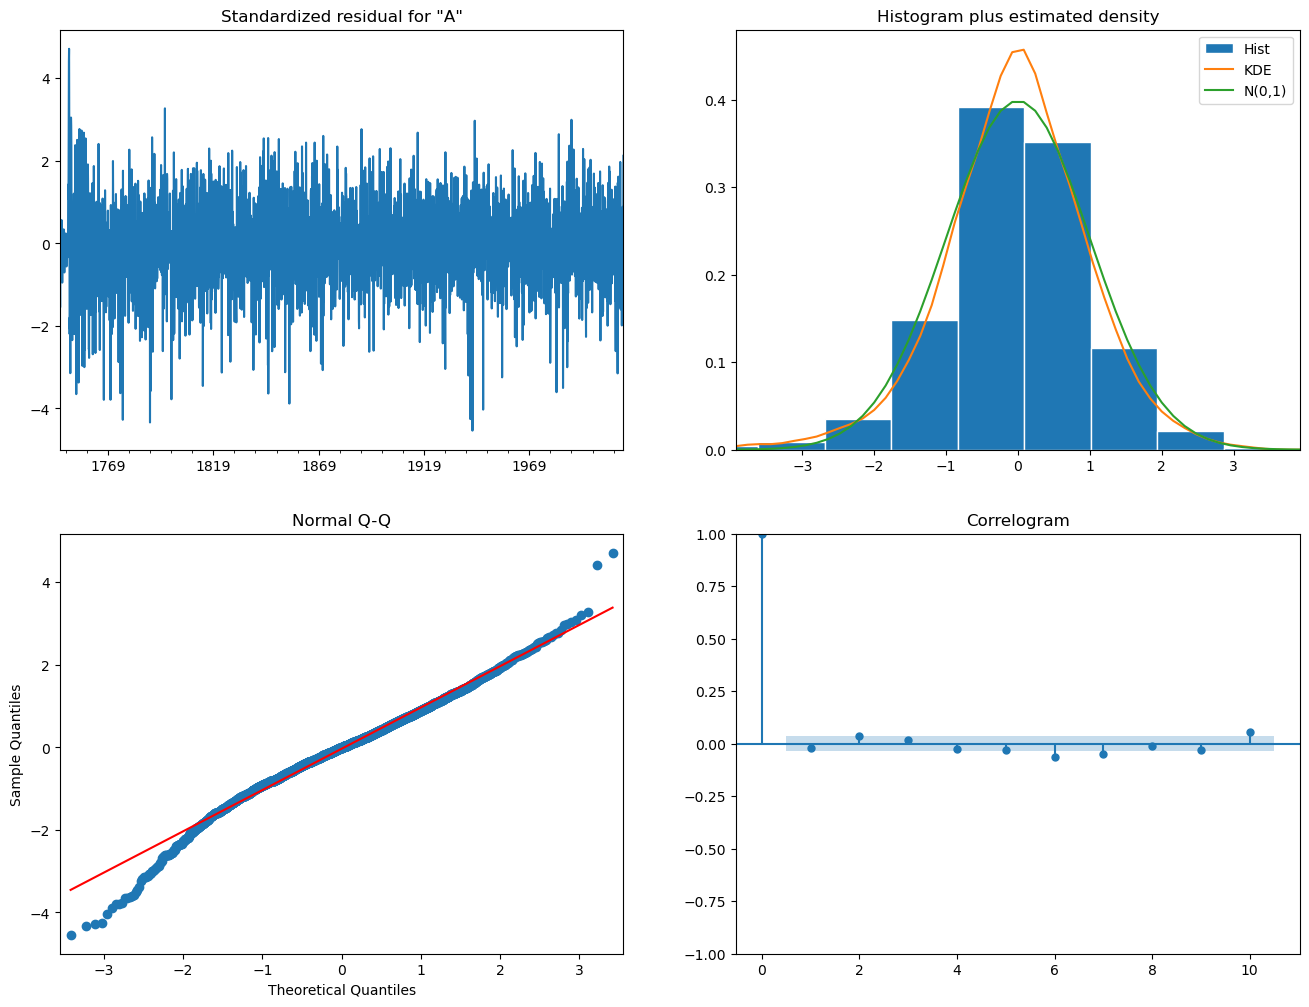

In [14]:
# Plot the model diagnostics
result.plot_diagnostics(figsize=(16, 12));

In [15]:
# Predict surface temperatures for the next four years
forecast = result.get_forecast(steps=48)
forecast.summary_frame()

AverageTemperature,mean,mean_se,mean_ci_lower,mean_ci_upper
2013-10-01,10.930482,1.684420,7.629079,14.231885
2013-11-01,6.190363,1.877803,2.509937,9.870789
2013-12-01,2.147526,1.924060,-1.623562,5.918614
2014-01-01,1.227960,1.936827,-2.568151,5.024072
2014-02-01,1.072544,1.940998,-2.731743,4.876831
2014-03-01,3.074108,1.942713,-0.733540,6.881756
2014-04-01,7.242807,1.943630,3.433361,11.052253
2014-05-01,12.279055,1.944253,8.468391,16.089720
2014-06-01,15.491776,1.944753,11.680130,19.303421
2014-07-01,17.853611,1.945200,14.041089,21.666132


Text(0.5, 1.0, 'Temperature Forecast with SARIMA')

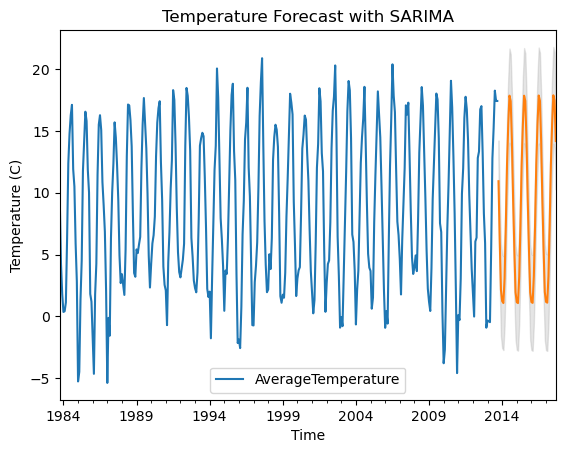

In [16]:
# Plot the surface temperature forecast
last_few_years = dates.tail(360)

ax1 = last_few_years.plot()
forecast.predicted_mean.plot(ax=ax1, label="Forecast")

ci = forecast.conf_int()
ax1.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color="gray", alpha=0.2)

ax1.set_xlabel("Time")
ax1.set_ylabel("Temperature (C)")
ax1.set_title("Temperature Forecast with SARIMA")

In [17]:
# Evaluate the performance of the model
pred_y = result.predict(start="1743-11-01", end="2013-09-01")

mseSARIMA = mean_squared_error(dates, pred_y)
modelMSE["SARIMA"] = mseSARIMA

### Model 3: Random Forest ###

In [18]:
# Import required packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [19]:
# Load the cleaned dataset
city_temps_rf = pd.read_csv("data/city_temps_cleaned.csv", index_col=0)
df = city_temps_rf.copy()

In [20]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,6.012,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,5.956,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,5.900,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,5.844,NaN,Århus,Denmark,57.05N,10.33E


In [21]:
# Split dataset into training and test sets
df['Latitude-Direction'] = df['Latitude'].str[-1]
df['Longitude-Direction'] = df['Longitude'].str[-1]
df['Latitude-Value'] = pd.to_numeric(df['Latitude'].str[0:-1])
df['Longitude-Value'] = pd.to_numeric(df['Longitude'].str[0:-1])
df['dt'] = pd.to_datetime(df['dt'])
df['year'] = df['dt'].dt.year
df['month'] = df['dt'].dt.month.astype(str)
long_direc = pd.get_dummies(df['Longitude-Direction'])
lat_direc = pd.get_dummies(df['Latitude-Direction'])
month = pd.get_dummies(df['month'])
df = df.join([long_direc, lat_direc, month])

df = df[df['dt'] > '1900-01-01']

In [22]:
prep_df = df[['AverageTemperature', 'Latitude-Value', 'Longitude-Value', 'year', 'E', 'N', 'S', 'W', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']].copy()

In [23]:
prep_df.head()

,AverageTemperature,Latitude-Value,Longitude-Value,year,E,N,S,W,1,2,3,4,5,6,7,8,9,10,11,12
1875,-2.799,57.05,10.33,1900,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1876,0.592,57.05,10.33,1900,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1877,4.630,57.05,10.33,1900,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1878,9.576,57.05,10.33,1900,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1879,15.888,57.05,10.33,1900,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [24]:
X_train, X_test, y_train, y_test = train_test_split(prep_df.iloc[:,1:], prep_df.iloc[:,0], test_size= 0.2, shuffle=True)

In [25]:
# Train the Random Forest model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
predictYrf = rf.predict(X_test)

# Evaluate the performance of the model
mseRF = mean_squared_error(y_test, predictYrf)
modelMSE["Random Forest"] = mseRF

### Model 4: Decision Tree ###

In [26]:
# Import required package
from sklearn.tree import DecisionTreeRegressor

# Train the Decision Tree model
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
predictY = clf.predict(X_test)

# Evaluate the performance of the model
mseDT = mean_squared_error(y_test, predictY)
modelMSE["Decision Tree"] = mseDT

### Model 5: XGBoost ###

In [27]:
# Import required package
from xgboost import XGBRegressor

# Train the XGBoost model
boost = XGBRegressor()
boost.fit(X_train, y_train)
boost_predict = boost.predict(X_test)

# Evaluate the performance of the model
mseBoost = mean_squared_error(y_test, boost_predict)
modelMSE["XGBoost"] = mseBoost

## Prediction Model Evaluation ##

***Compare the mean squared error (MSE) values from each of the models. The most suitable model will be that with the lowest mean squared error value.***

In [28]:
eval_df = pd.DataFrame.from_dict(modelMSE, orient='index', columns=['Mean Squared Error'])
eval_df.insert(0, 'Model', list(modelMSE.keys()))
eval_df.sort_values(by='Mean Squared Error', ascending=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)

eval_table = tabulate(eval_df, headers=['Model', 'Mean Squared Error'], tablefmt='fancy_grid')
print(eval_table)

╒════╤═══════════════╤══════════════════════╕
│    │ Model         │   Mean Squared Error │
╞════╪═══════════════╪══════════════════════╡
│  0 │ Random Forest │             0.308818 │
├────┼───────────────┼──────────────────────┤
│  1 │ Decision Tree │             0.407894 │
├────┼───────────────┼──────────────────────┤
│  2 │ LSTM          │             0.851568 │
├────┼───────────────┼──────────────────────┤
│  3 │ XGBoost       │             2.67919  │
├────┼───────────────┼──────────────────────┤
│  4 │ SARIMA        │             2.93499  │
╘════╧═══════════════╧══════════════════════╛


*The Random Forest model is the best performing model, and is used for predicting future surface temperatures.*

***Use the trained Random Forest model to predict the temperatures for the next 114 years***

In [29]:
# Since the df only contains information about the month and geographical location, just increasing the year 
# value should give us the required data for prediction in the future 
prep_df['year'] = prep_df['year'] + 114

In [30]:
future_test = prep_df.iloc[:, 1:]
future_test.head()

,Latitude-Value,Longitude-Value,year,E,N,S,W,1,2,3,4,5,6,7,8,9,10,11,12
1875,57.05,10.33,2014,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1876,57.05,10.33,2014,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1877,57.05,10.33,2014,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1878,57.05,10.33,2014,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1879,57.05,10.33,2014,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [31]:
future_pred = rf.predict(future_test)

## Prediction File Creation ##

In [32]:
# Prediction file creation based on Random Forest model
df = pd.read_csv("data/city_temps_cleaned.csv", index_col=0)
useful_cols = ['dt', 'AverageTemperature', 'City', 'Country', 'Latitude', 'Longitude']
df = df[useful_cols]
df['dt'] = pd.to_datetime(df['dt'])
df.drop(df[df.dt <= '1900-01-01'].index, inplace=True)

original = df.copy()
df.to_csv("data/original.csv", index=False, header=True)

In [33]:
original.head()

,dt,AverageTemperature,City,Country,Latitude,Longitude
1875,1900-02-01,-2.799,Århus,Denmark,57.05N,10.33E
1876,1900-03-01,0.592,Århus,Denmark,57.05N,10.33E
1877,1900-04-01,4.630,Århus,Denmark,57.05N,10.33E
1878,1900-05-01,9.576,Århus,Denmark,57.05N,10.33E
1879,1900-06-01,15.888,Århus,Denmark,57.05N,10.33E


In [34]:
# Adjust dataframe to form prediction file
df['dt'] = df['dt'] + pd.offsets.DateOffset(years=114)
df['AverageTemperature'] = future_pred

In [35]:
prediction = df.copy()
df.to_csv("data/predictions.csv", index=False, header=True)

In [36]:
prediction.head()

,dt,AverageTemperature,City,Country,Latitude,Longitude
1875,2014-02-01,-0.36022,Århus,Denmark,57.05N,10.33E
1876,2014-03-01,-0.39153,Århus,Denmark,57.05N,10.33E
1877,2014-04-01,5.55043,Århus,Denmark,57.05N,10.33E
1878,2014-05-01,12.77613,Århus,Denmark,57.05N,10.33E
1879,2014-06-01,15.32191,Århus,Denmark,57.05N,10.33E


In [37]:
combined_df = pd.concat([original, prediction], axis=0)

In [38]:
combined_df['dt'] = pd.to_datetime(combined_df['dt'])
combined_df['year'] = combined_df['dt'].dt.year
combined_df['month'] = combined_df['dt'].dt.month.astype(str)
combined_df.reset_index(drop=True, inplace=True)

In [39]:
combined_df.head()

,dt,AverageTemperature,City,Country,Latitude,Longitude,year,month
0,1900-02-01,-2.799,Århus,Denmark,57.05N,10.33E,1900,2
1,1900-03-01,0.592,Århus,Denmark,57.05N,10.33E,1900,3
2,1900-04-01,4.630,Århus,Denmark,57.05N,10.33E,1900,4
3,1900-05-01,9.576,Århus,Denmark,57.05N,10.33E,1900,5
4,1900-06-01,15.888,Århus,Denmark,57.05N,10.33E,1900,6


In [40]:
combined_df.to_csv("data/orig+pred.csv", index=False, header=True)

In [41]:
for i, x in combined_df.groupby('year'):
    p = os.path.join(os.getcwd(), "data/data_{}.csv".format(i))
    x.to_csv(p, index=False)